In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# import tensorflow as tf
import functools
import jax.numpy as jnp
import os
import json_lines
import numpy as np
import json

import jax
from jax.experimental import optimizers
from src import data, model_utils, optim_utils, measurements
from renn.rnn import cells, unroll, network
from renn import utils
import renn

from data_processing import analysis_utils as au
from renn import analysis_utils as renn_au

import tensorflow_datasets as tfds

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

## Performances vs. L2 and learning rate

In [30]:
LEARNING_RATES = [0.001, 0.003, 0.01, 0.03, 0.1] 
L2_PENALTIES = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

results = {}

In [31]:
def parse_folder(f):
    s = f.split('_')
    arch = s[0]
    eta = s[2]
    L2 = s[4]
    return arch, eta, L2

In [44]:
def extract_test_acc(f):
    with open(os.path.join(f, 'test_acc.jsonl')) as fi:
        x = json_lines.reader(fi)
        return list(x)[-1]['value']

In [45]:
base_folder = 'results/yelp/five_class/'

folders = os.listdir(base_folder)
for folder in folders:
    arch, eta, L2 = parse_folder(folder)
    value = extract_test_acc(os.path.join(base_folder, folder))
    results[(arch, float(eta), float(L2))] = value

In [46]:
def group(full_results, arch):
    LEARNING_RATES = [0.001, 0.003, 0.01, 0.03, 0.1] 
    L2_PENALTIES = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    
    ret = np.array([[full_results[(arch, lr, l2)] for l2 in L2_PENALTIES] for lr in LEARNING_RATES])
    return ret

In [47]:
arch = 'GRU'
x = group(results, arch)

Text(0.5, 1.0, 'GRU')

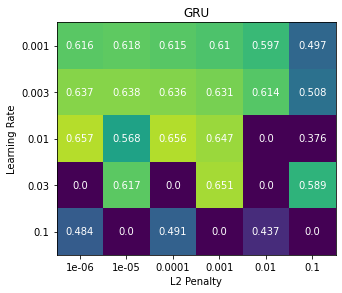

In [48]:
f, ax = plt.subplots(figsize=(5,10))
im = ax.imshow(x, cmap='viridis', vmin=0.4, vmax=1.05*np.max(x))

ax.set_yticks(np.arange(len(LEARNING_RATES)))
ax.set_yticklabels(LEARNING_RATES)
ax.set_ylabel('Learning Rate')

ax.set_xticks(np.arange(len(L2_PENALTIES)))
ax.set_xticklabels(L2_PENALTIES)
ax.set_xlabel('L2 Penalty')

for (j,i),label in np.ndenumerate(x):
    ax.text(i,j,np.round(label,3),ha='center',va='center', color='white')
    
ax.set_title(f'{arch}')

## Model and data loading

In [389]:
data_folder = 'results/yelp/five_class/LSTM_eta_0.003_L2_0.01_run_gq3pijgf/'

In [390]:
with open(os.path.join(data_folder, 'config.json')) as f:
    config = json.load(f)

In [391]:
with open(os.path.join(data_folder, 'test_acc.jsonl')) as f:
    x = f.readlines()
x[-1]

'{"step": 5040, "value": 0.6158809533074782}\n'

### Data loading

In [392]:
vocab_size, train_dset, test_dset = data.get_dataset(config['data'])
print("Data config\n")
print(config['data'])

Data config

{'dataset': 'yelp', 'batch_size': 256, 'max_pad': 800, 'num_classes': 5}


### Model loading

In [393]:
cell = model_utils.get_cell(config['model']['cell_type'],
                            num_units=config['model']['num_units'])

In [394]:
init_fun, apply_fun, emb_apply, readout_apply = network.build_rnn(vocab_size,
                                                                  config['model']['emb_size'],
                                                                  cell,
                                                                  num_outputs=config['model']['num_outputs'])
emb_init, emb_apply = renn.embedding(vocab_size, 
                                     config['model']['emb_size'])

In [395]:
network_params = model_utils.load_params(os.path.join(data_folder, 'final_params'))
emb_params, rnn_params, readout_params = network_params

#### Checksums

We check if the accuracy and the L2 norm of the parameters match what we expect from the data (json) files.

In [396]:
optimizers.l2_norm(rnn_params)

DeviceArray(14.688234, dtype=float32)

## Analysis

### PCA

In [397]:
transform_to_use = 'final'

In [398]:
test_batch = next(iter(tfds.as_numpy(test_dset)))

In [399]:
visited_states = {'original': au.rnn_states(cell, test_batch, rnn_params, emb_params, emb_apply)}
final_states = {'original': au.rnn_end_states(cell, test_batch, rnn_params, emb_params, emb_apply)}

In [400]:
PCA_objects = {'visited': au.PCA_rnn(),
               'final': au.PCA_rnn(),
               'fixed': au.PCA_rnn()}

PCA_objects['visited'].fit(np.vstack(visited_states['original']))
PCA_objects['final'].fit(np.vstack(final_states['original']))

PCA_rnn()

In [401]:
len(final_states['original'])

256

In [402]:
visited_states['transformed'] = [PCA_objects[transform_to_use].transform(v) for v in visited_states['original']]
final_states['transformed'] = [PCA_objects[transform_to_use].transform(f) for f in final_states['original']]

In [403]:
dimensionalities = {'visited': au.cumulative_var_explained(PCA_objects['visited']),
                    'final': au.cumulative_var_explained(PCA_objects['final'])}

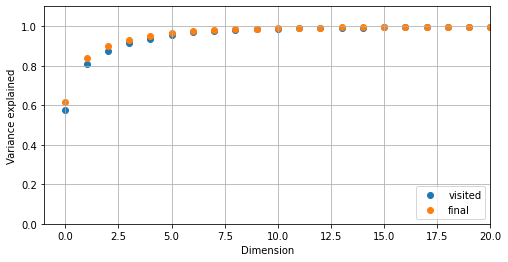

In [404]:
f = au.plot_varexp(dimensionalities)

In [405]:
coordinates = ['original', 'transformed']

visited_by_value = {c: au.states_by_value(visited_states[c], test_batch['labels'], config['data']['num_classes']) for c in coordinates}
final_by_value = {c: au.states_by_value(final_states[c], test_batch['labels'], config['data']['num_classes']) for c in coordinates}

### Trajectory visualization

In [406]:
initial_state_vector = {'original': cell.get_initial_state(rnn_params, batch_size=1)}
initial_state_vector['transformed'] = PCA_objects[transform_to_use].transform(initial_state_vector['original'])

In [407]:
readout_vectors = {'original': readout_params[0].T}
readout_vectors['transformed'] = PCA_objects[transform_to_use].transform_no_mean(readout_vectors['original'])

In [408]:
reload(au)

<module 'data_processing.analysis_utils' from '/usr/local/google/home/ramasesh/Projects/rnn_dynamics/data_processing/analysis_utils.py'>

(-5.888195538520813, 7.4408035516738895, -4.418781518936157, 5.015612840652466)

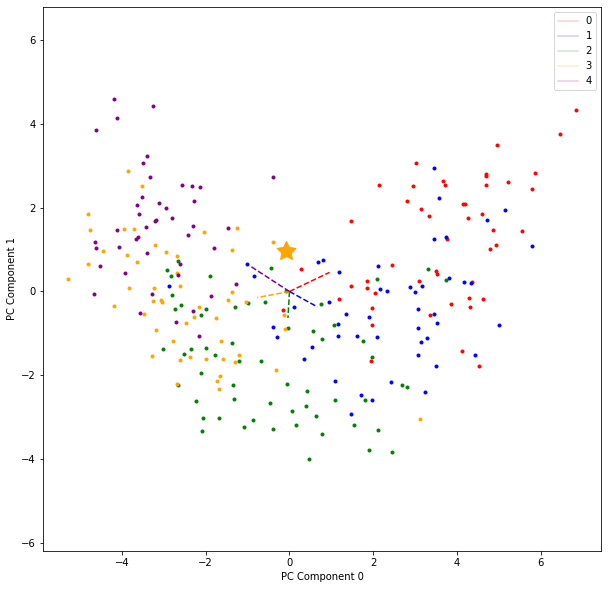

In [409]:
fig, ax = au.plot_states(final_by_value['transformed'], 
            readout_vectors['transformed'], 
            initial_state_vector['transformed'], 
            pc_dimensions=[0,1])
plt.axis('equal')

In [410]:
plt.figure(figsize=(10,10))

def plot_traj(ang1, ang2):
    fig, ax = au.plot_states(final_by_value['transformed'], 
                readout_vectors['transformed'], 
                initial_state_vector['transformed'], 
                pc_dimensions=[0,1, 2])

    ax.view_init(ang1, ang2)    
    
interact(plot_traj, ang1=widgets.FloatSlider(value=0, min=0, max=180, step=3),
                    ang2=widgets.FloatSlider(value=0, min=0, max=180, step=3))

<Figure size 720x720 with 0 Axes>

interactive(children=(FloatSlider(value=0.0, description='ang1', max=180.0, step=3.0), FloatSlider(value=0.0, …

<function __main__.plot_traj(ang1, ang2)>

### Slowness 

In [411]:
x_lim = 10
y_lim = 10

density = 100 

x_range = np.linspace(-x_lim, x_lim, density)
y_range = np.linspace(-y_lim, y_lim, density)


In [412]:
dimension = PCA_objects[transform_to_use].n_components_
coordinates = {0: x_range, 
               1: y_range}

pca_plane = renn_au.pseudogrid(coordinates, dimension)

In [413]:
pca_transformed = PCA_objects[transform_to_use].inverse_transform(pca_plane)

In [414]:
fp_loss_fn = renn.build_fixed_point_loss(cell, rnn_params)

In [415]:
input_lin = jnp.zeros((pca_transformed.shape[0], config['model']['emb_size']))
fp_l = fp_loss_fn(pca_transformed, input_lin)

(-0.5, 99.5, 99.5, -0.5)

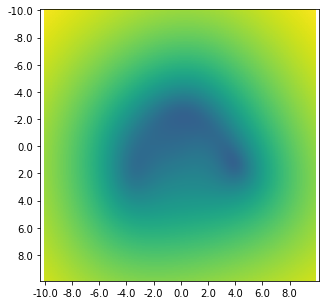

In [423]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(np.log10(fp_l).reshape(density, density), cmap='viridis', vmin=-3.5, vmax=1.)
ax.set_xticks(range(len(x_range))[::10])
ax.set_xticklabels(np.round(x_range.T[::10]));
ax.set_yticks(range(len(y_range))[::10])
ax.set_yticklabels(np.round(y_range.T[::10]));
plt.axis('equal')

In [424]:
np.min(np.log10(fp_l))

-2.1069527

/usr/local/google/home/ramasesh/VirtualEnvs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


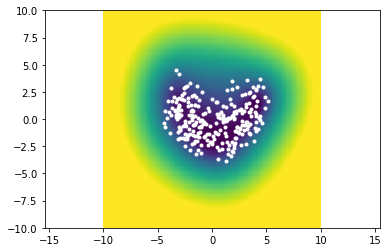

In [429]:
plt.pcolormesh(x_range, y_range, np.log10(fp_l).reshape(density, density), cmap='viridis', vmin=-2, vmax=+0.)
plt.axis('equal')
plt.scatter(fixed_points['transformed'][:,0], fixed_points['transformed'][:,1], color='white', marker='.')

In [1726]:
max(np.log10(fp_l))

0.9341761

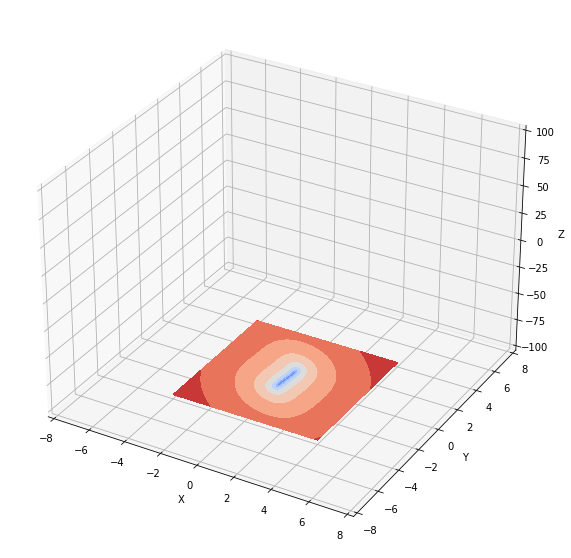

In [1727]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
# X, Y, Z = axes3d.get_test_data(0.05)

Z = np.log10(fp_l).reshape(density, density)

cset = ax.contourf(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(-x_lim, x_lim)
ax.set_ylabel('Y')
ax.set_ylim(-y_lim, y_lim)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)

plt.show()


### FIxed-point finding

In [426]:
fixed_points_, loss_hist, fp_losses = au.fixed_points(cell,
                                                    rnn_params,
                                                    final_states['original'],
                                                    tolerance=5e-6,
                                                    embedding_size=config['model']['emb_size'],
                                                    noise_scale=.5,
                                                    decimation_factor=1
                                                    )

fixed_points = {'original': fixed_points_,
                'transformed': PCA_objects[transform_to_use].transform(fixed_points_)}

Text(0, 0.5, 'Fixed point loss')

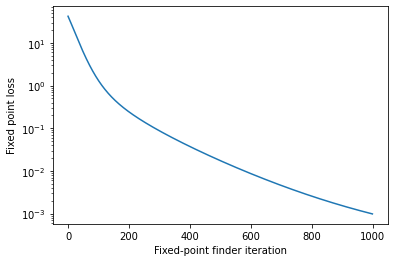

In [427]:
plt.semilogy(loss_hist)
plt.xlabel('Fixed-point finder iteration')
plt.ylabel('Fixed point loss')

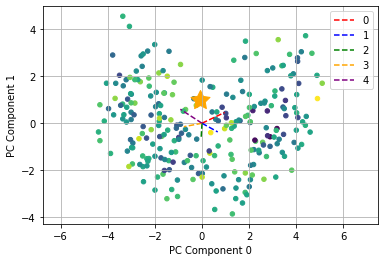

In [428]:
au.plot_fp_2d(fixed_points['transformed'],
              fp_losses,
              readout_vectors['transformed'],
              initial_state_vector['transformed'], 
              pc_dimensions=[0,1])
plt.axis('equal');

In [430]:
reload(au)

<module 'data_processing.analysis_utils' from '/usr/local/google/home/ramasesh/Projects/rnn_dynamics/data_processing/analysis_utils.py'>

(-5.312406063079834, 5.399890422821045, -5.312406063079834, 5.399890422821045)

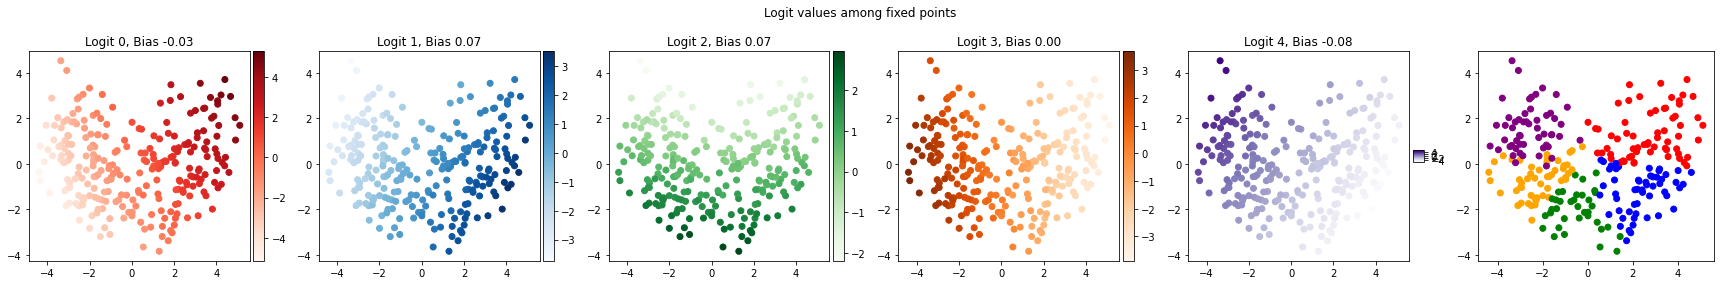

In [431]:
au.plot_logits(readout_apply, readout_params, fixed_points['original'], PCA_objects[transform_to_use]);
plt.axis('equal')

In [432]:
PCA_objects['fixed'].fit(fixed_points['original'])
dimensionalities['fixed']= au.cumulative_var_explained(PCA_objects['fixed'])

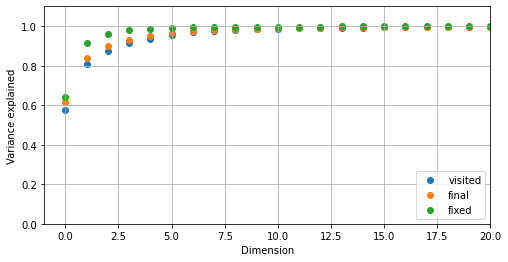

In [433]:
f = au.plot_varexp(dimensionalities)

In [353]:
dimensionalities['visited']

array([0.62786096, 0.7490527 , 0.822768  , 0.860799  , 0.892043  ,
       0.916096  , 0.9357949 , 0.9520964 , 0.96428794, 0.97128767,
       0.97666436, 0.98118675, 0.9853445 , 0.98792803, 0.98964614,
       0.991177  , 0.9923562 , 0.99332774, 0.9941738 , 0.994895  ,
       0.9955561 , 0.996144  , 0.9966972 , 0.99709874, 0.9974254 ,
       0.9977302 , 0.9979905 , 0.9982053 , 0.9983747 , 0.99852073,
       0.9986517 , 0.9987716 , 0.9988813 , 0.9989804 , 0.9990752 ,
       0.9991545 , 0.9992225 , 0.9992802 , 0.9993323 , 0.99937695,
       0.99941593, 0.99945176, 0.99948454, 0.9995161 , 0.9995444 ,
       0.99957216, 0.9995964 , 0.99961823, 0.99963915, 0.99965763,
       0.9996755 , 0.99969167, 0.9997071 , 0.99972117, 0.99973494,
       0.9997478 , 0.9997594 , 0.9997703 , 0.9997807 , 0.9997902 ,
       0.9997992 , 0.9998076 , 0.99981534, 0.99982274, 0.9998297 ,
       0.99983644, 0.9998429 , 0.999849  , 0.99985486, 0.9998604 ,
       0.99986583, 0.99987066, 0.9998753 , 0.99987954, 0.99988

### Visualizing some trajectories

In [214]:
reload(au)

<module 'data_processing.analysis_utils' from '/usr/local/google/home/ramasesh/Projects/rnn_dynamics/data_processing/analysis_utils.py'>

In [215]:
visited_by_value['transformed'].keys()

dict_keys([0, 1, 2, 3, 4])

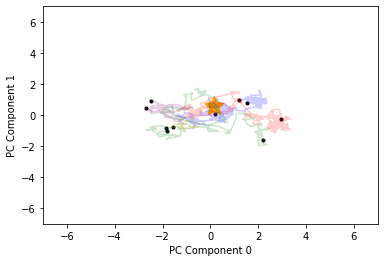

In [216]:
slice_to_plot = [10,20]
au.plot_traj_2d(visited_states['transformed'][slice_to_plot[0]:slice_to_plot[1]],
                pc_dimensions = [0,1],
                labels=test_batch['labels'][slice_to_plot[0]:slice_to_plot[1]],
                initial_state = initial_state_vector['transformed'],
                xlim=7, ylim=7)

In [217]:
xs = np.vstack(visited_states['transformed'])[:,0]
ys = np.vstack(visited_states['transformed'])[:,1]

(-3.994591236114502,
 4.096146583557129,
 -2.9266276359558105,
 2.9492764472961426)

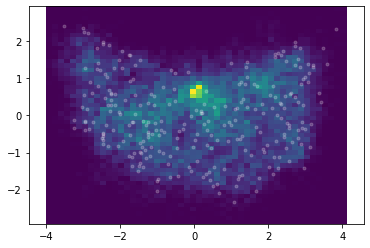

In [218]:
plt.hist2d(xs, ys,bins=50, density=True);
plt.scatter(fixed_points['transformed'][:,0], fixed_points['transformed'][:,1], color='white', marker='.', alpha=0.2)
plt.axis('equal')

### How many integrator eigenmodes?

In [452]:
fixed_point_index = 38

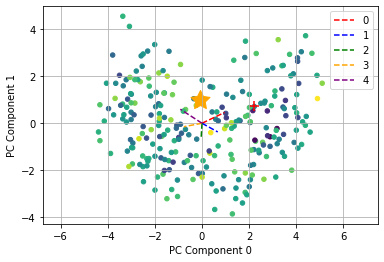

In [453]:
au.plot_fp_2d(fixed_points['transformed'],
              fp_losses,
              readout_vectors['transformed'],
              initial_state_vector['transformed'], 
              pc_dimensions=[0,1],
              point_to_highlight=fixed_point_index)

In [454]:
J_hh = cell.rec_jac(rnn_params, 
             jnp.zeros(config['model']['emb_size']), 
             fixed_points['original'][fixed_point_index])

R, E, L = renn.eigsorted(J_hh)

Text(0, 0.5, 'imag')

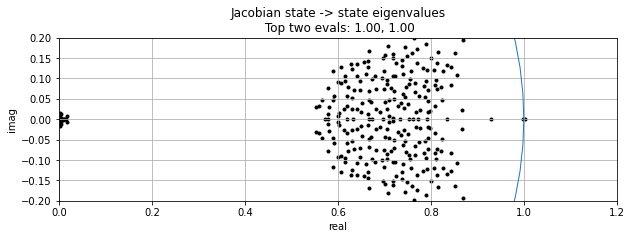

In [455]:
plt.figure(figsize=(10, 3))
plt.grid()
plt.scatter(np.real(E), np.imag(E), c='k', marker='.')
plt.xlim(0.0, 1.2)
plt.ylim(-0.2, 0.2)

t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1)

plt.title(f'Jacobian state -> state eigenvalues\n Top two evals: {np.real(E[0]):0.2f}, {np.real(E[1]):0.2f}')
plt.xlabel('real')
plt.ylabel('imag')

Text(0, 0.5, 'imag')

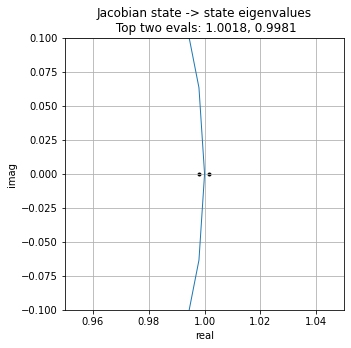

In [456]:
plt.figure(figsize=(5, 5))
plt.grid()
plt.scatter(np.real(E), np.imag(E), c='k', marker='.')
plt.xlim(0.95, 1.05)
plt.ylim(-0.1, 0.1)

t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1)

plt.title(f'Jacobian state -> state eigenvalues\n Top two evals: {np.real(E[0]):0.4f}, {np.real(E[1]):0.4f}')
plt.xlabel('real')
plt.ylabel('imag')

In [457]:
list(reversed(sorted(np.round(np.abs(1./np.log(np.abs(E)))))))[:10]

[569.0, 521.0, 14.0, 9.0, 9.0, 8.0, 8.0, 7.0, 7.0, 7.0]

### Effect of individual words

In [387]:
initial_pts = fixed_points['original']
l = fp_losses

In [367]:
encoder, _, _ = data.yelp(config['data']['max_pad'],
                          config['data']['batch_size'],
                          config['data']['num_classes'])

In [368]:
encoder.decode(test_batch['inputs'][5])

'Went here for Friday Night Fish Fry (after reading a decent review of the place from one of the fish fry ranking sites).  The place is T-I-N-Y tiny, but that\'s not a bad thing.  There are a handful of tables around the outside of the bar, and about 25-30 seats at the actual bar itself.  A low ceiling lends to the really smallish feel of the place.\\n\\nGreat jukebox, great service, good value.  We really enjoyed hanging out at the Villa Tap.  \\n\\nDrinks: we tried the whiskey old fashioned sour.  Lost points for not being muddled and for not using Squirt.  It was decent, regardless, and a great value; three old fashioneds came in at under $10.\\n\\nFood-wise - mixed results.  The appetizers (onion rings and cheese curds) were excellent.  Some of the best we\'ve ever had, even if the curds were \\"out of the box\\" curds.  They were cooked perfectly, didn\'t show any signs of grease, and were absolutely wonderful.\\n\\nThe fish - we had deep fried cod all around - left much to be des

In [ ]:
word = 'good '
encoder.encode(word)

In [378]:
word_input_ = emb_apply(emb_params, encoder.encode(word))
word_input = jnp.repeat(word_input_, initial_pts.shape[0], axis=0)

In [379]:
transformed = PCA_objects[transform_to_use].transform(initial_pts).T

final_pts = cell.batch_apply(rnn_params, word_input, initial_pts)
transformed_final = PCA_objects[transform_to_use].transform(final_pts).T

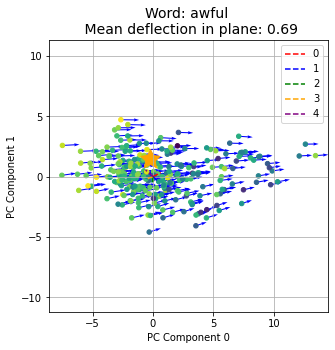

In [380]:
initial_states = [transformed[0], transformed[1]]
final_states = np.array([transformed_final[0], transformed_final[1]])

deltas = final_states - np.array(initial_states)

plt.figure(figsize=(5,5))
plt.quiver(initial_states[0], initial_states[1], deltas[0], deltas[1], scale=1, units='xy', color='blue')
plt.axis('equal')

s = np.mean(deltas**2)

plt.title(f'Word: {word} \n Mean deflection in plane: {s:0.2f}', fontsize=14)
plt.xlabel('PC 0 component')
plt.ylabel('PC 1 component')

# plt.scatter(initial_states[0], initial_states[1], c = np.log10(l), marker='.')
au.plot_fp_2d(fixed_points['transformed'],
              fp_losses,
              readout_vectors['transformed'],
              initial_state_vector['transformed'], 
              pc_dimensions=[0,1])
plt.axis('equal');



(0.0, 30.0)

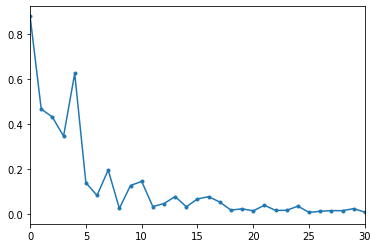

In [278]:
plt.plot(np.mean(np.abs(transformed_final - transformed), axis=1), marker = '.')
plt.xlim(0,30)

## Hunting for context

### Is there a context effect at all?

Before looking at changes to input Jacobians, we can first check whether a phrase like "not great" moves the hidden state in a different way than "great", or also "great not".  

In [1747]:
sequence = ['very ','good ']
inp_nums = [encoder.encode(s)[0] for s in sequence]

In [1748]:
inp_nums

[3075, 104]

In [1749]:
pts = initial_pts
for word in sequence:
    word_input_ = emb_apply(emb_params, encoder.encode(word))
    word_input = jnp.repeat(word_input_, initial_pts.shape[0], axis=0)
    pts = cell.batch_apply(rnn_params, word_input, pts)


In [1750]:
transformed_final = PCA_objects[transform_to_use].transform(pts).T

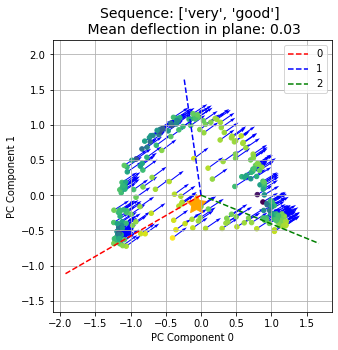

In [1751]:
initial_states = [transformed[0], transformed[1]]
final_states = np.array([transformed_final[0], transformed_final[1]])

deltas = final_states - np.array(initial_states)

plt.figure(figsize=(5,5))
plt.quiver(initial_states[0], initial_states[1], deltas[0], deltas[1], scale=1, units='xy', color='blue')
plt.axis('equal')

s = np.mean(deltas**2)

plt.title(f'Sequence: {sequence} \n Mean deflection in plane: {s:0.2f}', fontsize=14)
plt.xlabel('PC 0 component')
plt.ylabel('PC 1 component')

# plt.scatter(initial_states[0], initial_states[1], c = np.log10(l), marker='.')
au.plot_fp_2d(fixed_points['transformed'],
              fp_losses,
              readout_vectors['transformed'],
              initial_state_vector['transformed'], 
              pc_dimensions=[0,1])
plt.axis('equal');



#### All words at once

In [1752]:
words = ['extremely', 'good']

sequences = [[words[0]], [words[1]], words, words[::-1]]

finals_by_order = {}

for order in range(4):

    sequence = sequences[order]
    print(sequence)
    inp_nums = [encoder.encode(s)[0] for s in sequence]
    
    pts = initial_pts
    for word in sequence:
        word_input_ = emb_apply(emb_params, encoder.encode(word))
        word_input = jnp.repeat(word_input_, initial_pts.shape[0], axis=0)
        pts = cell.batch_apply(rnn_params, word_input, pts)

    finals_by_order[tuple(sequence)] = pts
    
    

['extremely']
['good']
['extremely', 'good']
['good', 'extremely']


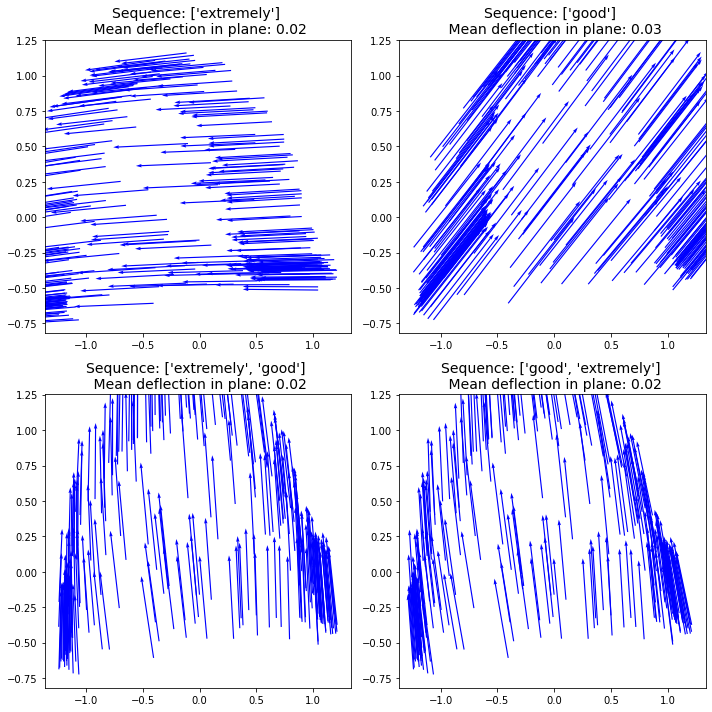

In [1753]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

for i in range(4):
    sequence = sequences[i]
    transformed_final = PCA_objects[transform_to_use].transform(finals_by_order[tuple(sequence)]).T
    
    initial_states = [transformed[0], transformed[1]]
    final_states = np.array([transformed_final[0], transformed_final[1]])

    deltas = final_states - np.array(initial_states)
    
    ax[i//2][i%2].quiver(initial_states[0], initial_states[1], deltas[0], deltas[1], scale=.3, units='xy', color='blue')

    s = np.mean(deltas**2)

    ax[i//2][i%2].set_title(f'Sequence: {sequence} \n Mean deflection in plane: {s:0.2f}', fontsize=14)

    plt.tight_layout()